# Multiple Regression Analysis Notebook

This notebook performs multiple regression analysis on fields in a dataset.

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import statsmodels.api as sm

## Step 1: Load the file and join with Student Performance data

In [41]:
# Replace 'your_dataset.csv' with the path to your dataset
file1_path = 'datasets/Student Engagement Level-Binary.csv'
file2_path = 'datasets/Student Performance Prediction-Multi.csv'
data1 = pd.read_csv(file1_path)
data2 = pd.read_csv(file2_path)

# Display the first few rows of the dataset
print("Dataset 1:")
display(data1.head())
print("\nDataset 2:")
display(data2.head())

join_field = 'Student ID'  # Specify the column used for joining

# Perform the join
merged_data = pd.merge(data1, data2, on=join_field, how='inner')

print("\nMerged Dataset:")
display(merged_data.head())

Dataset 1:


,Student ID,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level
0,student000000,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,H
1,student000001,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,L
2,student000002,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,L
3,student000003,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,L
4,student000004,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,L



Dataset 2:


,Student ID,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,student000000,95,91,70,90,84,64,85,85,G
1,student000001,85,76,65,61,73,64,76,76,G
2,student000002,85,41,73,61,73,61,73,73,G
3,student000003,80,78,80,79,79,57,80,79,G
4,student000004,85,91,78,80,84,67,85,85,G



Merged Dataset:


,Student ID,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),...,Engagement Level,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,student000000,143,344,58,0,3,0,0,0,178.166667,...,H,95,91,70,90,84,64,85,85,G
1,student000001,70,342,0,0,4,0,0,0,294.033333,...,L,85,76,65,61,73,64,76,76,G
2,student000002,42,219,0,0,3,0,0,0,169.600000,...,L,85,41,73,61,73,61,73,73,G
3,student000003,92,271,2,0,6,0,0,0,341.150000,...,L,80,78,80,79,79,57,80,79,G
4,student000004,116,379,0,0,1,0,0,0,325.500000,...,L,85,91,78,80,84,67,85,85,G


## Step 2: Remove outliers, standardise and normalise data

In [42]:
def clean_standardize_normalize(df):
    """Loads, cleans, removes outliers, standardizes, and normalizes a dataset from a CSV file."""

    # 1. Handle missing values
    print("Handling missing values...")
    df.fillna(df.median(numeric_only=True), inplace=True)  # Fill NaNs with median for numeric columns
    df.fillna("", inplace=True)  # Fill NaNs in categorical columns with empty string

    # 2. Convert categorical variables to numeric (One-Hot Encoding)
    print("Encoding categorical features...")
    df = pd.get_dummies(df, drop_first=True)  # Convert categorical to numeric

    # 3. Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # 4. Outlier Removal (Z-score & IQR)
    print("Removing outliers...")
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Z-score method (removes values beyond 3 standard deviations)
    df_no_outliers = df[(np.abs(df[numeric_features].apply(zscore)) < 3).all(axis=1)]

    # IQR method (removes values beyond 1.5 * IQR)
    Q1 = df_no_outliers[numeric_features].quantile(0.25)
    Q3 = df_no_outliers[numeric_features].quantile(0.75)
    IQR = Q3 - Q1
    df_no_outliers = df_no_outliers[~((df_no_outliers[numeric_features] < (Q1 - 1.5 * IQR)) |
                                      (df_no_outliers[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

    # 6. Remove Influential Points using Cook’s Distance
    print("Removing influential data points...")
    X = sm.add_constant(df_no_outliers[numeric_features])  # Add intercept for regression
    #y = df_no_outliers[numeric_features].iloc[:, 0]  # Select first column as target (modify as needed)
    y = df_no_outliers['Course Grade']
    
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    # Define threshold (commonly 4/n)
    threshold = 4 / len(df_no_outliers)
    df_cleaned = df_no_outliers[cooks_d < threshold]

    # 7. Standardization (Mean=0, Std=1)
    print("Standardizing data...")
    scaler_standard = StandardScaler()
    df_standardized = pd.DataFrame(scaler_standard.fit_transform(df_cleaned[numeric_features]), 
                                   columns=numeric_features)

    # 8. Normalization (0-1 Scaling)
    print("Normalizing data...")
    scaler_minmax = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler_minmax.fit_transform(df_cleaned[numeric_features]), 
                                 columns=numeric_features)

    # Save cleaned versions
    # print("Saving cleaned datasets...")
    # df_cleaned.to_csv("cleaned_data.csv", index=False)
    # df_standardized.to_csv("standardized_data.csv", index=False)
    # df_normalized.to_csv("normalized_data.csv", index=False)

    print("Data cleaning complete! Choose the version you want to use for Lasso.")

    return df_cleaned, df_standardized, df_normalized


df_cleaned, df_standardized, df_normalized = clean_standardize_normalize(merged_data)

print("Cleaned data:")
display(df_cleaned.head())

print("Standardised data:")
display(df_standardized.head())

print("Normalized data:")
display(df_normalized.head())


Handling missing values...
Encoding categorical features...
Removing outliers...
Removing influential data points...
Standardizing data...
Normalizing data...
Data cleaning complete! Choose the version you want to use for Lasso.
Cleaned data:


,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),...,Student ID_student000479,Student ID_student000480,Student ID_student000481,Student ID_student000482,Student ID_student000483,Student ID_student000484,Student ID_student000485,Engagement Level_L,Class_G,Class_W
1,70,342,0,0,4,0,0,0,294.033333,196.083333,...,False,False,False,False,False,False,False,True,True,False
4,116,379,0,0,1,0,0,0,325.500000,236.283333,...,False,False,False,False,False,False,False,True,True,False
5,62,358,0,0,0,0,0,0,182.800000,89.883333,...,False,False,False,False,False,False,False,False,True,False
6,76,213,0,0,0,0,0,0,220.600000,200.483333,...,False,False,False,False,False,False,False,True,True,False
7,78,237,0,0,3,0,0,0,171.216667,91.333333,...,False,False,False,False,False,False,False,False,False,False


Standardised data:


,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100]
0,-0.249320,0.835622,0.0,0.0,1.537328,0.0,0.0,0.0,0.908865,0.811851,0.723233,0.832623,0.695057,-0.287265,-1.547792,-2.270006,-1.329127,0.015618,-0.905994,-0.918296
1,1.598718,1.238266,0.0,0.0,-0.516918,0.0,0.0,0.0,1.299098,1.323793,1.262603,1.322985,0.695057,1.072061,-0.105507,-0.038384,0.091140,0.262821,0.304636,0.292325
2,-0.570717,1.009739,0.0,0.0,-1.201667,0.0,0.0,0.0,-0.470591,-0.540592,-0.658130,-0.568177,0.102613,-0.015400,0.449219,0.783793,-0.167090,-0.313985,0.035607,0.023298
3,-0.008271,-0.568189,0.0,0.0,-1.201667,0.0,0.0,0.0,-0.001816,0.867885,0.811699,0.567518,-1.082275,1.072061,0.116384,0.079070,-0.554436,0.757226,0.304636,0.292325
4,0.072078,-0.307015,0.0,0.0,0.852579,0.0,0.0,0.0,-0.614241,-0.522126,-0.606263,-0.593839,-0.489831,-1.284104,-1.769682,-1.095468,-0.683551,-2.703608,-2.520168,-2.532456


Normalized data:


,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100]
0,0.440945,0.594966,0.0,0.0,0.666667,0.0,0.0,0.0,0.725676,0.712998,0.692450,0.733521,0.625,0.566038,0.250,0.181818,0.270270,0.546875,0.351351,0.351351
1,0.803150,0.679634,0.0,0.0,0.166667,0.0,0.0,0.0,0.819588,0.863946,0.841992,0.873946,0.625,0.849057,0.575,0.613636,0.567568,0.593750,0.594595,0.594595
2,0.377953,0.631579,0.0,0.0,0.000000,0.0,0.0,0.0,0.393703,0.314225,0.309463,0.332374,0.500,0.622642,0.700,0.772727,0.513514,0.484375,0.540541,0.540541
3,0.488189,0.299771,0.0,0.0,0.000000,0.0,0.0,0.0,0.506516,0.729520,0.716978,0.657603,0.250,0.849057,0.625,0.636364,0.432432,0.687500,0.594595,0.594595
4,0.503937,0.354691,0.0,0.0,0.500000,0.0,0.0,0.0,0.359133,0.319670,0.323843,0.325025,0.375,0.358491,0.200,0.409091,0.405405,0.031250,0.027027,0.027027


## Step 3: Specify variables and perform Cross-Validation

In [43]:
# Define the target and predictors
target = 'Course Grade'  # Replace with your target column
features = ["# Logins", "# Content Reads", "# Forum Reads", "# Forum Posts", "# Quiz Reviews before submission",
              "Assignment 1 duration to submit (in hours)", "Assignment 2 duration to submit (in hours)", "Assignment 3 duration to submit (in hours)", 
              "Average time to submit assignment (in hours)"]  # Replace with your predictor columns

X = df_standardized[features]
y = df_standardized[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lasso with Cross-Validation to find the best alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=10, random_state=42)
lasso_cv.fit(X_train, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha:.5f}")

Best alpha: 0.05690


## Step 3: Run Lasso Regression

In [44]:
# Train final Lasso model with best alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# Predictions
y_pred = lasso.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"R-squared (R²): {r2:.5f}")

# Coefficients
coef_df = pd.DataFrame({'Feature': ['Intercept'] + features, 'Coefficient': [lasso.intercept_] + list(lasso.coef_)})
print("\nLasso Coefficients:")
print(coef_df)

Mean Squared Error (MSE): 0.96459
R-squared (R²): 0.07970

Lasso Coefficients:
                                        Feature  Coefficient
0                                     Intercept     0.027508
1                                      # Logins     0.218006
2                               # Content Reads    -0.000000
3                                 # Forum Reads     0.000000
4                                 # Forum Posts     0.000000
5              # Quiz Reviews before submission    -0.000000
6    Assignment 1 duration to submit (in hours)    -0.000000
7    Assignment 2 duration to submit (in hours)    -0.046264
8    Assignment 3 duration to submit (in hours)    -0.000000
9  Average time to submit assignment (in hours)    -0.000000


## Step 4: Plot feature importance

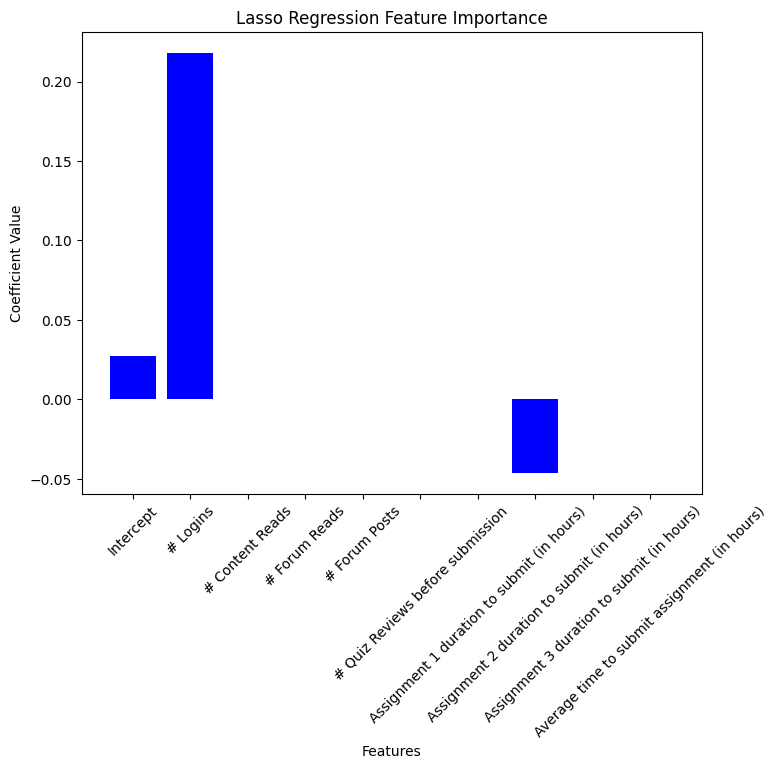

In [45]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Lasso Regression Feature Importance")
plt.xticks(rotation=45)
plt.show()